# Reconstruction of fast-ion distribution function in fusion plasmas

The first thin we will do is to import the CUQIpy software.

In [50]:
import cuqi

## Introduction and forward problem formulation
Here follows a short introduction to the physical and mathematical problem that we seek to solve.

In magnetically confined fusion plasmas the most energetic positively charged ions are dubbed fast ions, and a thorough understanding of their dynamics are vital in the pursuit of commercially available fusion energy. Fast ions are born as fusion products, needed for sustaining the high temperature of the plasma, can drive instabilities deteriorating the plasma confinement, but can also suppress turbulence. Thus, they are both a blessing and a curse, but definitely inevitable.

The fast-ion dynamics are captured in the fast-ion distribution function $f$, which is generally six dimensional, three position coordinates and three velocity coordinates,
$$
    f=f(\mathbf{x},\mathbf{v}).
$$
Taking advantage of symmetries of the system, we can reduce the number of dimensions. The plasma is confined in a tokamak, which is a toroidally symmetric fusion device. In a cylindrical coordinate system, we can therefore ignore the toroidal angle and reduce the number of position coordinates to two $(R,z)$. Likewise we can discard one velocity coordinate, since the mangetic moment of the fast ions is an adiabatic invariant. The magnetic moment is related to the gyromotion of the ions around the magnetic field lines, which can therefore be ignored. The fast-ion distribution function can thus be expressed in 4D.

The problem is that the fast-ion distribution function cannot be measured directly. However, we can measure diagnostic signals $s$ depending on the fast-ion distribution function and invert the relation to reconstruct $f$. For interactions between a fast ion and a much less energetic target $s$ depends linearly on $f$,
$$
    s(u_{1},u_{2},\varphi)=\int\int w(u_{1},u_{2},\varphi,\mathbf{x},\mathbf{v})f(\mathbf{x},\mathbf{v})\mathrm{d}\mathbf{x}\mathrm{d}\mathbf{v},
$$
Which is our forward problem. Discretising the forward problem, we have the matrix-vector product
$$
    \mathbf{s}=W\mathbf{f}
$$
where each row in $W$ is a weight function and $\mathbf{f}$ is the vectorised fast-ion distribution function.

Now we introduce strong prior information on the dynamics of fast ions. When fast ions are born in the plasma over time they collide the bulk of the plasma and slow down until reaching a steady state distribution, which we call a slowing-down distribution function. In this numerical experiment, we run a series of simulations initialising a number of fast ions in different sources placed strategiacally around the plasma volume, such that the resulting slowing-down distribution functions cover the entire phase space to a large degree. The assumption is now that the true fast-ion distribution functions in an experiment lies in the phase space spanned by these slowing-down distribution functions. Thus, we take each vectorised slowing-down distribution function to be a basis vector, such that the assumption reads
$$
    \mathbf{f}=\sum_{i=1}^{N_{\text{sd}}}c_{i}\mathbf{\psi}_{i}=\Psi\mathbf{c},
$$
where each column in the matrix $\Psi$ is a basis vector and the vector $\mathbf{c}$ contains all slowing-down coefficients. In this case we take $N_{\text{sd}}=30$, such that instead of reconstructing the entire phase-space, we seek to only reconstruct 30 coefficients. The forward problem now reads
$$
    s=W\Psi c=Ac.
$$
We will not go into details on how to calculate the weight matrix W or the slowing-down basis, so we just import $W\Psi=A$ as a .txt file, which has been created elsewhere. In addition to the weight matrix, we also import the observed noisy data and the true coefficients, which are the true solution.

In [51]:
import numpy as np

A = np.loadtxt('WPsi_matrix.txt')           # Discrete forward model A = WPsi
data = np.loadtxt('signal_obs.txt')         # Observed noisy data s
true_sol = np.loadtxt('true_SD_coeffs.txt') # True slowing-down coefficients c

Now we need to convert the weight matrix .txt file to a CUQI model with the proper geometry, and we convert the observed data and the exact solution to CUQI arrays. Then we plot the true synthtetic data and the observed noisy data. We will see that we have four detectors observing a spectrum each, where the signal from the two first detectors dominate the last two.

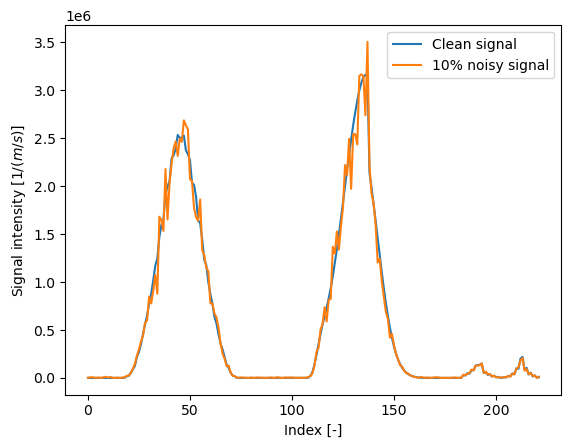

In [52]:
from cuqi.geometry import Image2D

WPsi = cuqi.model.LinearModel(A)
WPsi.domain_geometry = cuqi.geometry.Discrete(WPsi.domain_dim)
WPsi.range_geometry = cuqi.geometry.Discrete(WPsi.range_dim)
y_obs = cuqi.array.CUQIarray(data, geometry=cuqi.geometry.Discrete(WPsi.range_dim))
true_sol = cuqi.array.CUQIarray(true_sol, geometry=WPsi.domain_geometry)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(A@true_sol)
plt.plot(y_obs)
plt.xlabel('Index [-]')
plt.ylabel('Signal intensity $[1/(m/s)]$')
plt.legend(['Clean signal','10% noisy signal'])

## Prepare inverse problem
For physical reasons, which goes beyond what we wish to cover here, we expect every third slowing-down coefficient to lie on a smooth curve. That is the first, fourth, seventh coefficient etc. are related, as is the second, fifth, eighth and so on. We thus have three sets of 10 coefficients which we imagine lie on three smooth curves. Instead of reconstructing the slowing-down coefficients themselves we can reconstruct the smooth curves via polynomial interpolation and find the optimal polynomial coefficients instead. We choose to express the polynomials as linear combinations of the Chebyshev polynomials of the first kind. Since the slowing-down coefficients can be ordered arbitrarily, we are free to choose the interpolation points as we see like. To avoid Runge's phenomenon we choose the roots of the Chebyshev polynomials, i.e. the Chebyshev nodes $\mathbf{x}_{0}$, as the interpolation points. The slowing-down coefficients are thus
$$
    \mathbf{c}=(T\otimes\mathbb{I}_{3})\mathbf{a},\qquad 
    T=\begin{pmatrix} 
        | & \dots & |\\
        T_{0}(\mathbf{x}_{0}) & \dots & T_{N_{\text{sd}}/3-1}(\mathbf{x}_{0})\\
        | & \dots & |
    \end{pmatrix},
$$
where $\mathbb{I}_{3}$ is the three-by-three identity matrix and $T_{p}$ denotes the Chebyshev polynomial of order $p$. This incorporates more physical prior information into the problem by imposing that the slowing-down coefficients does not fluctuate wildly. We regularise the polynomial coefficients with a standard zeroth-order Tikhonov regularisation. The inverse problem then reads
$$
    \mathbf{a}_{\lambda}=\min_{\lambda}\left(||\hat{\mathbf{s}}-\hat{W}\Psi T\mathbf{a}||_{2}^{2}+\lambda^{2}||\mathbf{a}||_{2}^{2}\right).
$$
In the following code we will name the matrix $CV = T\otimes\mathbb{I}_{3}$ for "Chebyshev". The "hat" notation on $\hat{\mathbf{s}}$ and $\hat{W}$ refer to them being weighted by the data covariance matrix, which we define in the below.

In [53]:
from numpy.polynomial import chebyshev

CV = np.array(chebyshev.chebvander(chebyshev.chebpts1(WPsi.domain_dim/3),9)) # 10 pols. Chebyshev polynomials
CV = np.kron(CV,np.identity(3))                                              # Kronecker product with identity matrix
WPsiCV = WPsi@CV                                                             # New forward model
WPsiCV = cuqi.model.LinearModel(WPsiCV)                                      # Make model a CUQI model
WPsiCV.domain_geometry = cuqi.geometry.Discrete(WPsiCV.domain_dim)           # Define domain geometry
WPsiCV.range_geometry = cuqi.geometry.Discrete(WPsiCV.range_dim)             # Define range geometry

Now we create the data covariance matrix based on noise estimate. This is included in the likelihood, which goes into the posterior distribution function.

In [54]:
noiselevel = np.array([0.1*data])                                 # Assume 10% noise, which is actually correct.
noise_floor = np.array([(1e-3)*np.max(data)*np.ones(data.shape)]) # Make noise floor to avoid singularities when inverting
nn = np.concatenate((noiselevel, noise_floor), axis=0)  
noise = np.diag(np.max(nn, axis=0))                               # Make diagonal covariance matrix, i.e. uncorrelated noise

Now we are ready to create the Bayesian problem and perform uncertainty quantification analysis. Then we plot the results.

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using direct sampling of Gaussian posterior. Only works for small-scale problems with dim<=2000.
No burn-in needed for direct sampling.
 Sample 1000 / 1000
Elapsed time: 0.028486251831054688
Plotting results
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using direct MAP of Gaussian posterior. Only works for small-scale problems with dim<=2000.


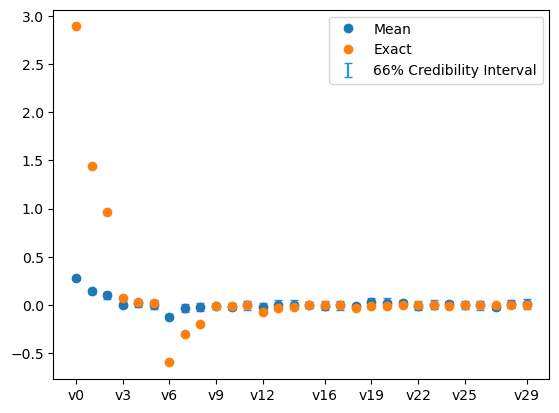

In [55]:
from cuqi.distribution import JointDistribution, Gaussian, CMRF, LMRF, GMRF

x = Gaussian(np.zeros(WPsiCV.domain_dim), 0.05**2)
y = Gaussian(mean=WPsiCV@x, cov=noise**2)

# Create Bayesian problem
from cuqi.problem import BayesianProblem

plt.figure()
BP = BayesianProblem(x, y)                   # Create Bayesian problem
BP.set_data(y=y_obs)                         # Provide observed data

from cuqi.sampler import LinearRTO, pCN, CWMH, ULA, MALA, NUTS

true_CVcoeffs = np.transpose(CV)@true_sol # Remember "true_sol" are the slowing-down coefficients, but we reconstruct the polynomial coefficients
true_CVcoeffs = cuqi.array.CUQIarray(true_CVcoeffs, geometry=WPsiCV.domain_geometry) # Have to make it a CUQIarray also
samples       = BP.UQ(exact=true_CVcoeffs, percent=66) # Run UQ analysis (comparing with exact solution)
MAP_est = BP.MAP()

Make a new plot, this time including errorbars calculated by error propagation.

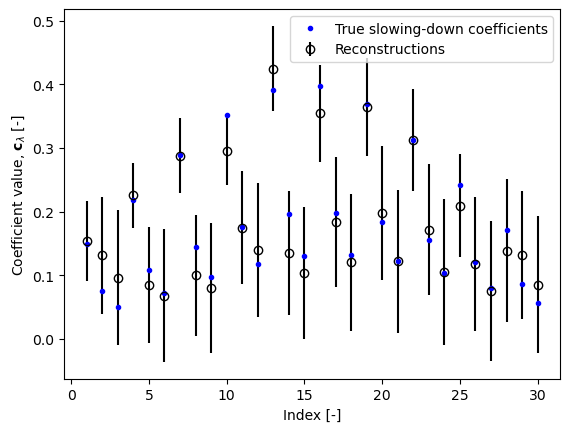

In [56]:
SD_coeff_uncertainties = np.diag(CV@np.diag(np.std(samples.samples, axis=1))@np.transpose(CV))
SD_coeff_samples = CV@samples.samples
plt.figure()
plt.errorbar(np.linspace(1,30,true_sol.shape[0]), CV@MAP_est, yerr=np.std(SD_coeff_samples, axis=1), ecolor='black', linestyle='', marker='o', mfc='None', mec='black')
#plt.errorbar(np.linspace(1,30,true_sol.shape[0]), CV@MAP_est, yerr=SD_coeff_uncertainties, ecolor='black', linestyle='', marker='o', mfc='None', mec='black')
plt.plot(np.linspace(1,30,true_sol.shape[0]),true_sol, 'b.')
plt.xlabel('Index [-]')
plt.ylabel('Coefficient value, $\mathbf{c}_{\lambda}$ [-]')
plt.legend(['True slowing-down coefficients', 'Reconstructions'])

Done!